# VGG 및 Inception 네트워크의 50층 구성에 따른 성능 및 Gradient 변화 분석

본 실험은 VGG와 Inception 계열 모델에서 층 수를 50개로 확장했을 때, 원래 구조와 비교하여 성능 변화 및 gradient 흐름에 어떤 차이가 발생하는지를 분석하였다.
실험에서는 backpropagation 과정 중 custom gradient 추적 모듈을 삽입하여 layer gradient을 기록하였다.

## 사전 지식

### 깊은 신경망과 Gradient 흐름
- 깊은 신경망에서는 계층 수가 많아질수록 학습이 어려워지는 현상이 발생한다.
- 대표적인 문제는 vanishing gradient로, 하위 계층의 gradient가 거의 0에 수렴하여 가중치 갱신이 이루어지지 않는 현상이다.
- 이러한 문제는 단순 CNN 구조(VGG 등)에서 두드러지며, 구조적 개선이 필요함을 시사한다.

In [44]:

from dataclasses import dataclass
import torch
import os

@dataclass
class Config:
    # Dataset
    dataset: str = 'cifar10'
    batch_size: int = 128
    num_workers: int = 4

    # Training
    epochs: int = 100
    learning_rate: float = 0.001
    weight_decay: float = 1e-4
    early_stopping_patience: int = 10

    # Model
    num_classes: int = 10

    # Gradient tracking
    gradient_tracking_interval: int = 3  # Track gradients every 3 epochs

    # Paths
    checkpoint_dir: str = 'checkpoints'
    results_dir: str = 'results'

    # Device
    device: str = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

    # Model specific
    vgg16_config = {
        'num_layers': 16,
        'features': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
    }

    vgg50_config = {
        'num_layers': 50,
        'features': [64] * 50  
    }


In [45]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class Inception(nn.Module):
    def __init__(self, in_channels: int, ch1x1: int, ch3x3red: int, ch3x3: int, ch5x5red: int, ch5x5: int, pool_proj: int):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)

class InceptionNet(nn.Module):
    def __init__(self, num_classes: int = 10):
        super(InceptionNet, self).__init__()
        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)

        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(832, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.a3(x)
        x = self.b3(x)
        x = self.maxpool(x)

        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)

        return x


In [46]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Optional

class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class Inception(nn.Module):
    def __init__(self, in_channels: int, ch1x1: int, ch3x3red: int, ch3x3: int, ch5x5red: int, ch5x5: int, pool_proj: int):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)

class Inception50(nn.Module):
    def __init__(self, num_classes: int = 10):
        super(Inception50, self).__init__()
        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)

        in_channels = 192
        self.inception_layers = nn.ModuleList()

        base_channel_configs = [
            (64, 96, 128, 16, 32, 32),   # Smaller block
            (128, 128, 192, 32, 96, 64), # Medium block
            (192, 96, 208, 16, 48, 64),  # Larger block
        ]

        num_inception_blocks = 8 

        current_in_channels = in_channels
        for i in range(num_inception_blocks):
            config_idx = i % len(base_channel_configs) 
            ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj = base_channel_configs[config_idx]


            next_in_channels = ch1x1 + ch3x3 + ch5x5 + pool_proj

            self.inception_layers.append(Inception(current_in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj))
            current_in_channels = next_in_channels

            # Add a MaxPool after certain blocks to reduce spatial dimensions, similar to GoogLeNet structure
            if i == 2 or i == 5: 
                self.inception_layers.append(nn.MaxPool2d(3, stride=2, padding=1))

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(current_in_channels, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[torch.Tensor]]:
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        aux1 = None # No direct auxiliary outputs in this simplified Inception50 structure
        aux2 = None

        for i, layer in enumerate(self.inception_layers):
            x = layer(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)

        return x, aux1, aux2


In [47]:

import torch
import torch.nn as nn
from typing import List, Union

class VGG16(nn.Module):
    def __init__(self, num_classes: int = 10):
        super(VGG16, self).__init__()
        self.features = self._make_layers([
            64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M',
            512, 512, 512, 'M', 512, 512, 512, 'M'
        ])
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _make_layers(self, cfg: List[Union[int, str]]) -> nn.Sequential:
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [48]:

import torch
import torch.nn as nn
from typing import List, Union

class VGG50(nn.Module):
    def __init__(self, num_classes: int = 10):
        super(VGG50, self).__init__()
        features = []
        in_channels = 3
        channels = [64, 128, 256, 512, 512]
        layers_per_block = 10  # 50 layers / 5 blocks = 10 layers per block

        for block_channels in channels:
            for _ in range(layers_per_block):
                features.extend([
                    nn.Conv2d(in_channels, block_channels, kernel_size=3, padding=1),
                    nn.BatchNorm2d(block_channels),
                    nn.ReLU(inplace=True)
                ])
                in_channels = block_channels
            features.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.features = nn.Sequential(*features)
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [49]:

import torch
import torch.nn as nn
from typing import Dict, List, Tuple, Optional
import numpy as np

class GradientTracker:
    def __init__(self, model: nn.Module, tracked_layers: Optional[List[str]] = None):
        self.model = model
        self.gradients: Dict[str, List[torch.Tensor]] = {}
        self.hooks = []
        self.tracked_layers = tracked_layers

    def _hook_fn(self, name: str) -> callable:
        def hook(grad):
            if self.tracked_layers and name not in self.tracked_layers:
                return 

            if name not in self.gradients:
                self.gradients[name] = []
            if isinstance(grad, torch.Tensor):
                self.gradients[name].append(grad.detach().cpu().numpy())
            else:
                self.gradients[name].append(None)
        return hook

    def register_hooks(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                if self.tracked_layers is None or name in self.tracked_layers:
                    self.hooks.append(param.register_hook(self._hook_fn(name)))

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

    def get_average_gradients(self) -> Dict[str, np.ndarray]:
        avg_gradients = {}
        for name, grads in self.gradients.items():
            valid_grads = [g for g in grads if g is not None]
            if valid_grads:
                avg_gradients[name] = np.mean(valid_grads, axis=0)
            else:
                avg_gradients[name] = None
        return avg_gradients

    def clear_gradients(self):
        self.gradients.clear()

class CustomBackprop:
    def __init__(self, model: nn.Module, criterion: nn.Module, tracked_layers: Optional[List[str]] = None):
        self.model = model
        self.criterion = criterion
        self.gradient_tracker = GradientTracker(model, tracked_layers) # Pass tracked_layers

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def backward(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[float, Dict[str, np.ndarray]]:
        # Register hooks for gradient tracking
        self.gradient_tracker.register_hooks()

        # Forward pass
        outputs = self.forward(x)

        # Handle auxiliary classifier outputs for Inception models
        if isinstance(outputs, tuple):
            main_output, aux1, aux2 = outputs
            loss = self.criterion(main_output, y)
            if aux1 is not None and aux2 is not None: # Check if auxiliary outputs exist
                loss += 0.3 * (self.criterion(aux1, y) + self.criterion(aux2, y))
        else:
            loss = self.criterion(outputs, y)

        # Backward pass
        loss.backward()

        # Get average gradients
        avg_gradients = self.gradient_tracker.get_average_gradients()

        # Clean up
        self.gradient_tracker.remove_hooks()
        self.gradient_tracker.clear_gradients()

        return loss.item(), avg_gradients

    def step(self, optimizer: torch.optim.Optimizer):
        optimizer.step()
        optimizer.zero_grad()


In [50]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from typing import Dict, List, Tuple, Optional
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


class Trainer:
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        criterion: nn.Module,
        optimizer: optim.Optimizer,
        device: str,
        config: Dict,
        model_name: str
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.config = config
        self.model_name = model_name

        # Select target layers for gradient tracking based on model_name
        self.tracked_layers = self._select_target_layers(model)
        self.custom_backprop = CustomBackprop(model, criterion, tracked_layers=self.tracked_layers)

        # Training history
        self.train_losses: List[float] = []
        self.val_losses: List[float] = []
        self.train_accs: List[float] = []
        self.val_accs: List[float] = []
        self.gradient_flows: List[Dict[str, List[float]]] = []

        # Best model tracking
        self.best_val_acc = 0.0
        self.best_model_path = os.path.join(config['checkpoint_dir'], f'{model_name}_best.pth')

        # Create directories if they don't exist
        os.makedirs(config['checkpoint_dir'], exist_ok=True)
        os.makedirs(config['results_dir'], exist_ok=True)

    def _select_target_layers(self, model: nn.Module) -> List[str]:
        """Dynamically selects relevant layers for gradient tracking."""
        all_param_names = [name for name, _ in model.named_parameters() if _.requires_grad]

        if not all_param_names:
            return []

        # Try to select first, middle, and last relevant layers
        target_layers = []

        # First layer
        if all_param_names:
            target_layers.append(all_param_names[0])

        # Middle layer 
        if len(all_param_names) > 2:
            middle_index = len(all_param_names) // 2
            target_layers.append(all_param_names[middle_index])

        # Last layer
        if len(all_param_names) > 1: 
            target_layers.append(all_param_names[-1])

        target_layers = list(dict.fromkeys(target_layers))

        print(f"Tracking gradients for layers: {target_layers}")
        return target_layers


    def train_epoch(self) -> Tuple[float, float, Optional[Dict[str, np.ndarray]]]:
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        # Initialize gradients for the epoch
        # Use self.tracked_layers to initialize only for tracked layers
        epoch_gradients: Dict[str, List[float]] = {name: [] for name in self.tracked_layers}

        for batch_idx, (inputs, targets) in enumerate(self.train_loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            # Forward and backward pass with custom backprop
            loss, gradients_batch = self.custom_backprop.backward(inputs, targets)

            # Accumulate gradients for logging
            for name, grad_np in gradients_batch.items():
                if name in epoch_gradients and grad_np is not None: 
                    epoch_gradients[name].append(np.linalg.norm(grad_np))

            # Optimizer step
            self.custom_backprop.step(self.optimizer)

            # Update statistics
            total_loss += loss
            outputs = self.model(inputs)

            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        avg_loss = total_loss / len(self.train_loader)
        accuracy = 100. * correct / total

        # Calculate average gradient norms for the epoch
        avg_epoch_gradients = {name: np.mean(grads) if grads else 0.0 for name, grads in epoch_gradients.items()}

        return avg_loss, accuracy, avg_epoch_gradients

    def validate(self) -> Tuple[float, float]:
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in self.val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                # If the model outputs a tuple, take the main output for validation accuracy
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                loss = self.criterion(outputs, targets)

                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        avg_loss = total_loss / len(self.val_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def train(self):
        patience_counter = 0

        for epoch in range(self.config['epochs']):
            # Training
            train_loss, train_acc, epoch_avg_gradients = self.train_epoch()
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)

            # Validation
            val_loss, val_acc = self.validate()
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            serializable_gradients = {
                name: float(grad) if isinstance(grad, (np.float32, np.float64)) else grad
                for name, grad in epoch_avg_gradients.items()
            }
            self.gradient_flows.append({
                'epoch': epoch,
                'gradients': list(serializable_gradients.values()),
                'layer_names': list(serializable_gradients.keys())
            })


            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), self.best_model_path)
                patience_counter = 0
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= self.config['early_stopping_patience']:
                print(f'Early stopping at epoch {epoch}')
                break

            # Print progress
            print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}%, \
                  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%')

        # After training, plot gradient flow over epochs for each layer
        self._plot_gradient_flow_over_epochs()


    def _plot_gradient_flow_over_epochs(self):
        """Plot how gradient flow changes over epochs for each layer"""
        if not self.gradient_flows:
            print("No gradient flow data to plot over epochs.")
            return

        epochs = [flow['epoch'] for flow in self.gradient_flows]

        # Get all unique layer names across all epochs that were tracked
        all_layer_names = sorted(list(set(name for flow in self.gradient_flows for name in flow['layer_names'])))

        plt.figure(figsize=(25, 12)) 

        # Create a dictionary to hold gradient norms for each layer over epochs
        layer_gradients_over_epochs = {name: [] for name in all_layer_names}

        for flow in self.gradient_flows:
            current_epoch_grads = dict(zip(flow['layer_names'], flow['gradients']))
            for layer_name in all_layer_names:
                # Append gradient norm if present, else append 0.0
                layer_gradients_over_epochs[layer_name].append(current_epoch_grads.get(layer_name, 0.0))

        for layer_name, gradients in layer_gradients_over_epochs.items():
            plt.plot(epochs, gradients, label=layer_name, alpha=0.7)

        plt.title(f'Gradient Flow Over Epochs ({self.model_name})')
        plt.xlabel('Epoch')
        plt.ylabel('Average Gradient Norm')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(self.config['results_dir'], f'{self.model_name}_gradient_flow_over_epochs.png'))
        plt.show()
        plt.close()

    def save_results(self):
        """Save training results and metrics"""
        serializable_gradient_flows = []
        for flow in self.gradient_flows:
            serializable_gradients = {
                name: float(grad) if isinstance(grad, (np.float32, np.float64)) else grad
                for name, grad in zip(flow['layer_names'], flow['gradients'])
            }
            serializable_gradient_flows.append({
                'epoch': flow['epoch'],
                'gradients': list(serializable_gradients.values()),
                'layer_names': list(serializable_gradients.keys())
            })

        def convert_numpy_to_python(obj):
            if isinstance(obj, np.generic):
                return obj.item()
            elif isinstance(obj, dict):
                return {k: convert_numpy_to_python(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [convert_numpy_to_python(elem) for elem in obj]
            return obj

        serializable_config = convert_numpy_to_python(self.config)

        results = {
            'config': serializable_config,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accs': self.train_accs,
            'val_accs': self.val_accs,
            'gradient_flows': serializable_gradient_flows,
            'best_val_acc': self.best_val_acc
        }

        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        results_path = os.path.join(self.config['results_dir'], f'{self.model_name}_results_{timestamp}.json')

        with open(results_path, 'w') as f:
            json.dump(results, f, indent=4)

        # Plot training curves
        plt.figure(figsize=(12, 4))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accs, label='Train Acc')
        plt.plot(self.val_accs, label='Val Acc')
        plt.title('Accuracy Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.config['results_dir'], f'{self.model_name}_training_curves_{timestamp}.png'))
        plt.show()
        plt.close()


Using device: cuda
Training Inception...
Tracking gradients for layers: ['conv1.conv.weight', 'b4.branch2.0.bn.bias', 'linear.bias']
Epoch 0: Train Loss: 1.4247, Train Acc: 54.7244%,                   Val Loss: 1.1676, Val Acc: 57.5400%
Epoch 1: Train Loss: 1.0223, Train Acc: 68.8333%,                   Val Loss: 0.9715, Val Acc: 66.5400%
Epoch 2: Train Loss: 0.8324, Train Acc: 75.8911%,                   Val Loss: 0.9022, Val Acc: 68.0600%
Epoch 3: Train Loss: 0.6953, Train Acc: 81.0911%,                   Val Loss: 0.7531, Val Acc: 73.3800%
Epoch 4: Train Loss: 0.5981, Train Acc: 84.8978%,                   Val Loss: 0.7557, Val Acc: 73.6800%
Epoch 5: Train Loss: 0.5073, Train Acc: 88.1844%,                   Val Loss: 0.7289, Val Acc: 75.5400%
Epoch 6: Train Loss: 0.4263, Train Acc: 91.3200%,                   Val Loss: 0.7655, Val Acc: 74.8000%
Epoch 7: Train Loss: 0.3662, Train Acc: 93.4933%,                   Val Loss: 0.8694, Val Acc: 73.2000%
Epoch 8: Train Loss: 0.3129, Train 

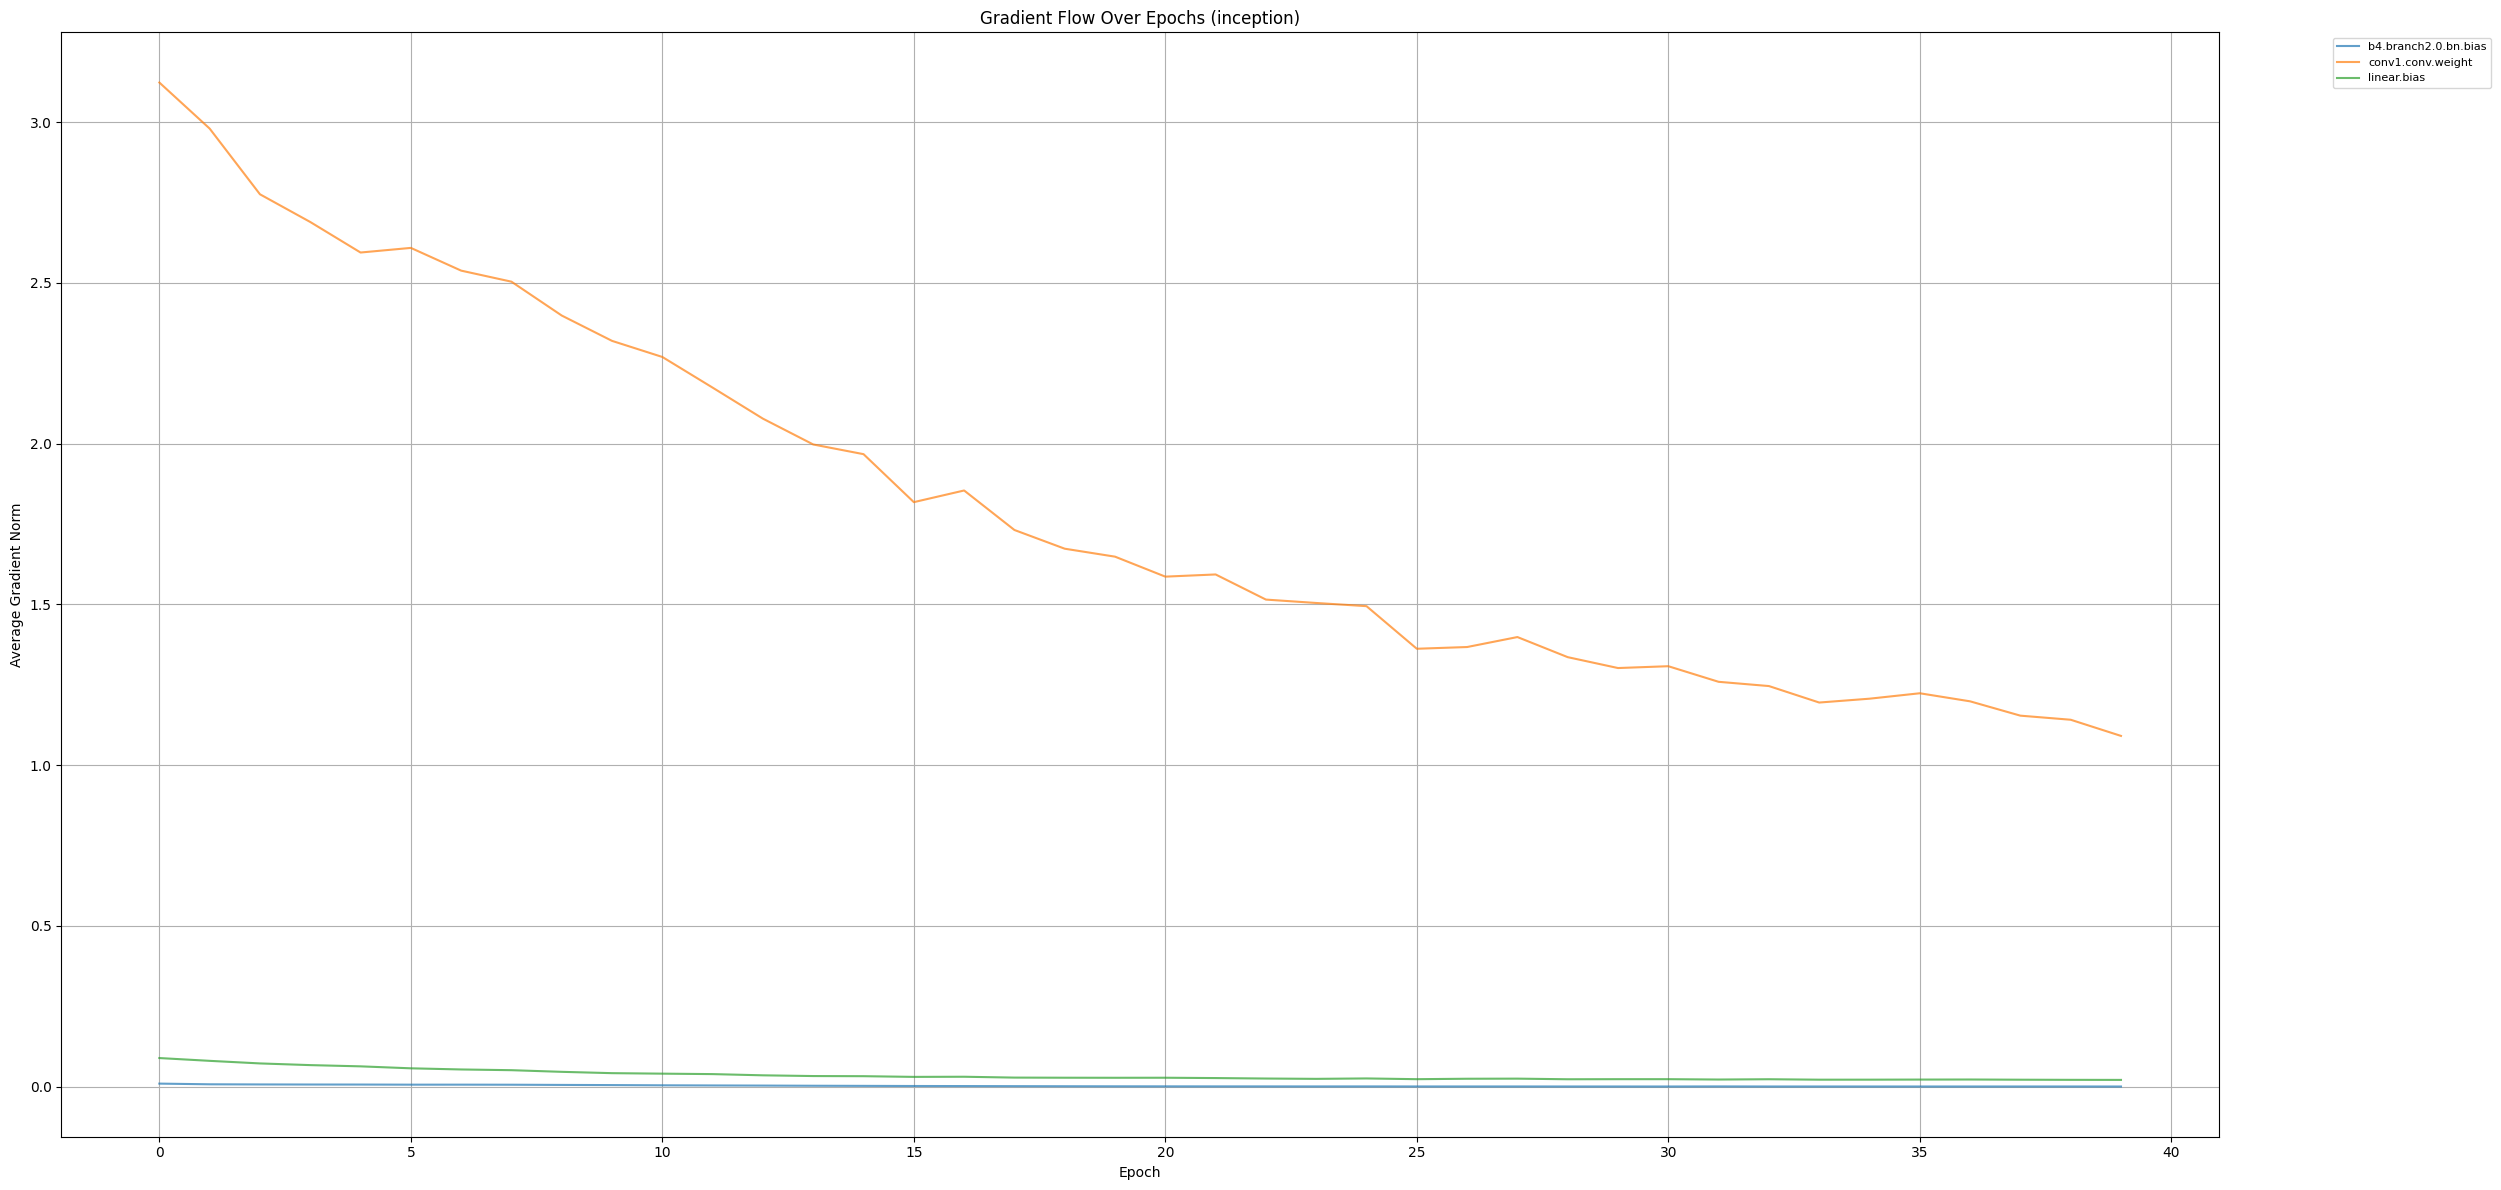

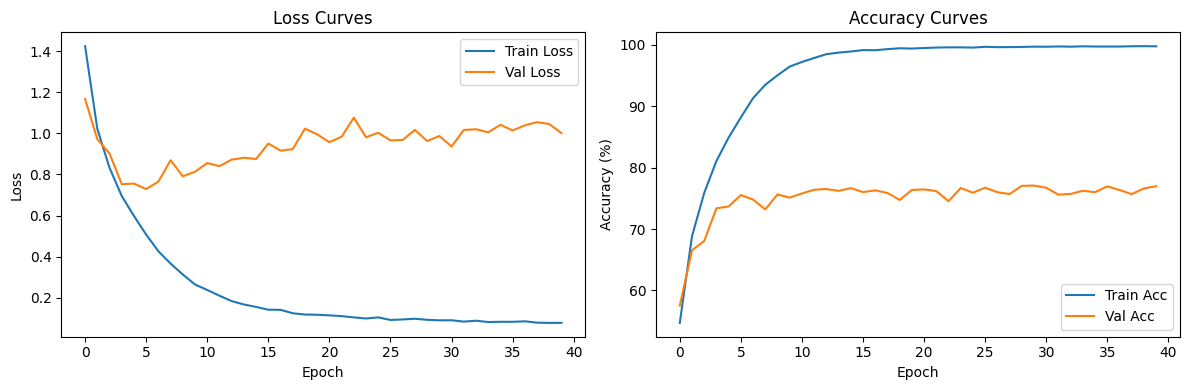

Training Inception50...
Tracking gradients for layers: ['conv1.conv.weight', 'inception_layers.4.branch3.1.bn.bias', 'linear.bias']
Epoch 0: Train Loss: 1.4888, Train Acc: 52.2356%,                   Val Loss: 1.2397, Val Acc: 55.6400%
Epoch 1: Train Loss: 1.0629, Train Acc: 67.2311%,                   Val Loss: 0.9625, Val Acc: 66.5000%
Epoch 2: Train Loss: 0.8608, Train Acc: 75.0533%,                   Val Loss: 0.8722, Val Acc: 69.6600%
Epoch 3: Train Loss: 0.7220, Train Acc: 80.1089%,                   Val Loss: 0.7499, Val Acc: 73.5800%
Epoch 4: Train Loss: 0.6218, Train Acc: 84.1333%,                   Val Loss: 0.7810, Val Acc: 72.6200%
Epoch 5: Train Loss: 0.5381, Train Acc: 87.1178%,                   Val Loss: 0.7306, Val Acc: 75.6400%
Epoch 6: Train Loss: 0.4623, Train Acc: 90.0844%,                   Val Loss: 0.8009, Val Acc: 73.9600%
Epoch 7: Train Loss: 0.4032, Train Acc: 92.2844%,                   Val Loss: 0.7879, Val Acc: 75.4400%
Epoch 8: Train Loss: 0.3448, Train A

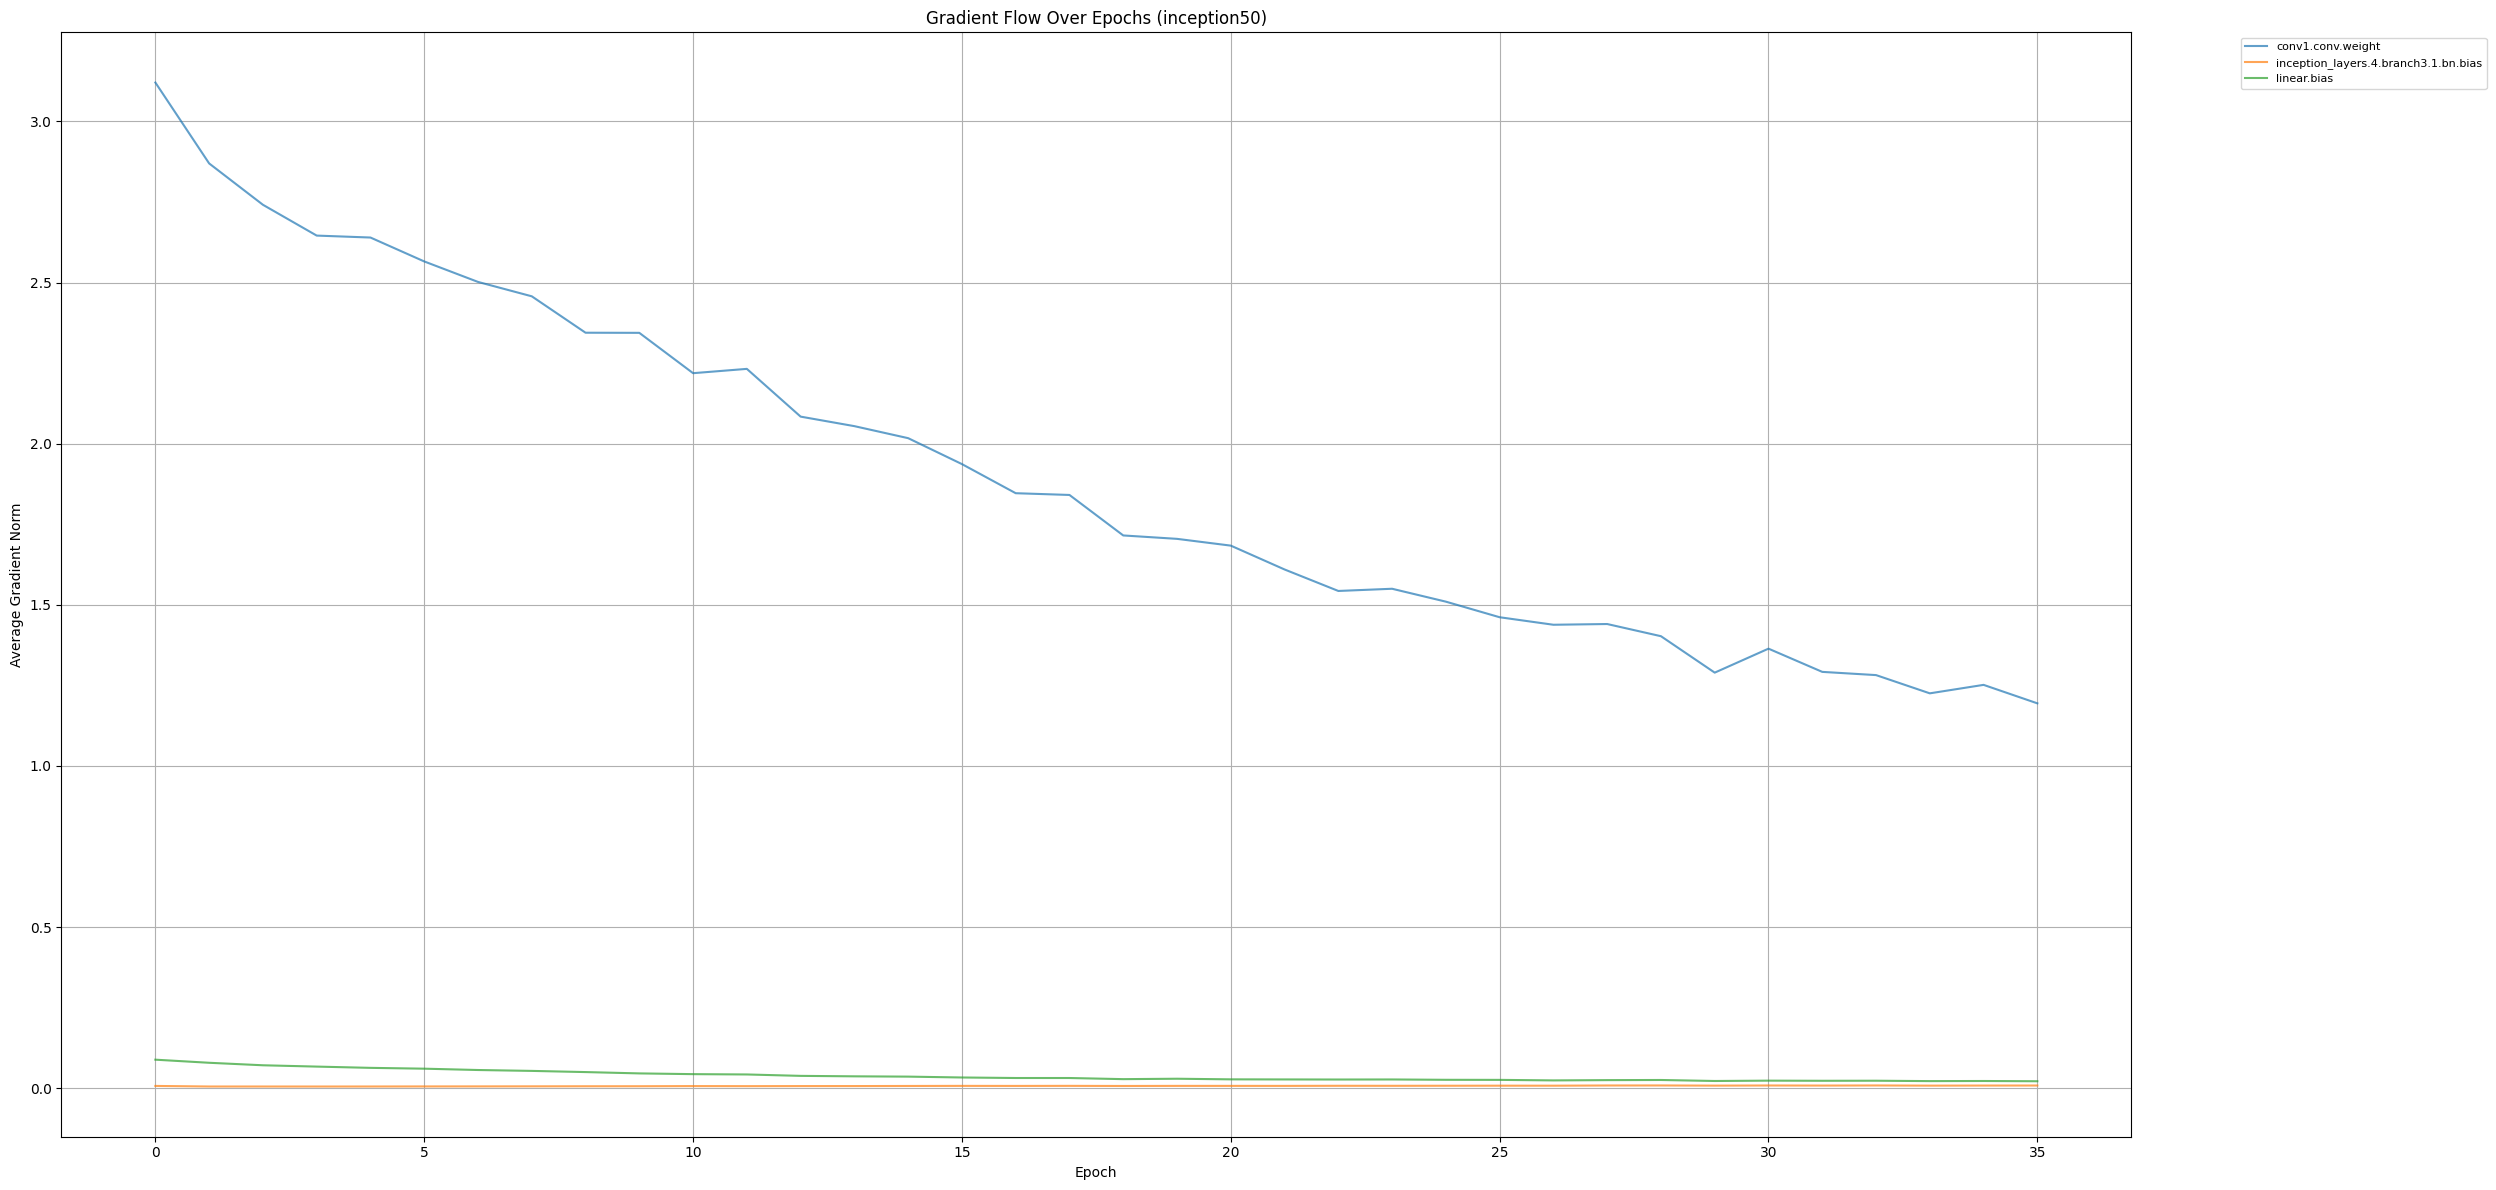

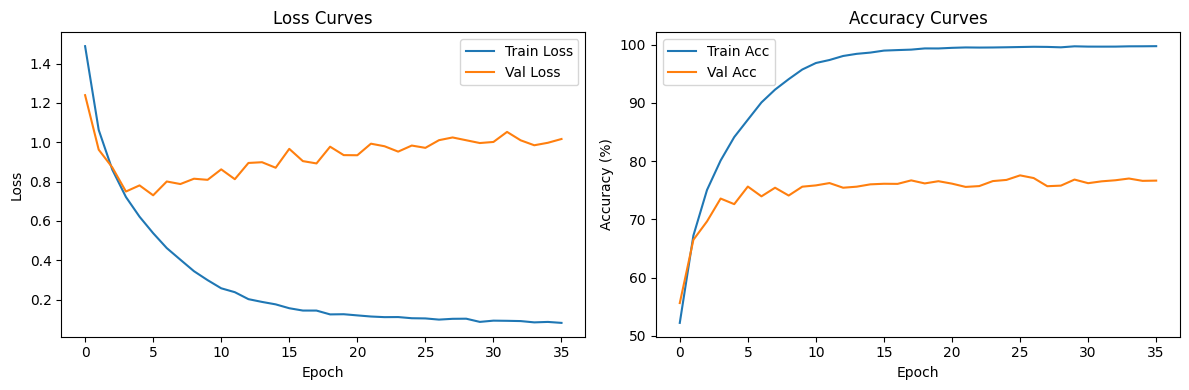

In [51]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
import sys



def main():
    # Load configuration
    config = Config()

    # Set device
    device = torch.device(config.device)
    print(f"Using device: {device}")

    # Data transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load CIFAR-10 dataset
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Split training data into train and validation
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

    # Create models
    inception = InceptionNet(num_classes=config.num_classes).to(device)
    inception50 = Inception50(num_classes=config.num_classes).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    # Train Inception
    print("Training Inception...")
    inception_optimizer = optim.Adam(inception.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    inception_trainer = Trainer(
        model=inception,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=inception_optimizer,
        device=device,
        config=vars(config),
        model_name='inception'
    )
    inception_trainer.train()
    inception_trainer.save_results()

    # Train Inception50
    print("Training Inception50...")
    inception50_optimizer = optim.Adam(inception50.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    inception50_trainer = Trainer(
        model=inception50,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=inception50_optimizer,
        device=device,
        config=vars(config),
        model_name='inception50'
    )
    inception50_trainer.train()
    inception50_trainer.save_results()

if __name__ == '__main__':
    main()


Using device: cuda
Training VGG16...
Tracking gradients for layers: ['features.0.weight', 'features.24.bias', 'classifier.6.bias']
Epoch 0: Train Loss: 1.8949, Train Acc: 21.5778%,                   Val Loss: 1.7286, Val Acc: 30.7200%
Epoch 1: Train Loss: 1.5930, Train Acc: 36.3222%,                   Val Loss: 1.4820, Val Acc: 38.6000%
Epoch 2: Train Loss: 1.4002, Train Acc: 45.2333%,                   Val Loss: 1.2605, Val Acc: 51.2000%
Epoch 3: Train Loss: 1.2195, Train Acc: 57.3756%,                   Val Loss: 1.1684, Val Acc: 57.3600%
Epoch 4: Train Loss: 1.0246, Train Acc: 66.6267%,                   Val Loss: 0.9427, Val Acc: 67.3600%
Epoch 5: Train Loss: 0.8768, Train Acc: 72.7089%,                   Val Loss: 0.8860, Val Acc: 67.8200%
Epoch 6: Train Loss: 0.7667, Train Acc: 77.1222%,                   Val Loss: 0.8176, Val Acc: 71.8600%
Epoch 7: Train Loss: 0.6795, Train Acc: 80.4867%,                   Val Loss: 0.7119, Val Acc: 76.1800%
Epoch 8: Train Loss: 0.6021, Train Ac

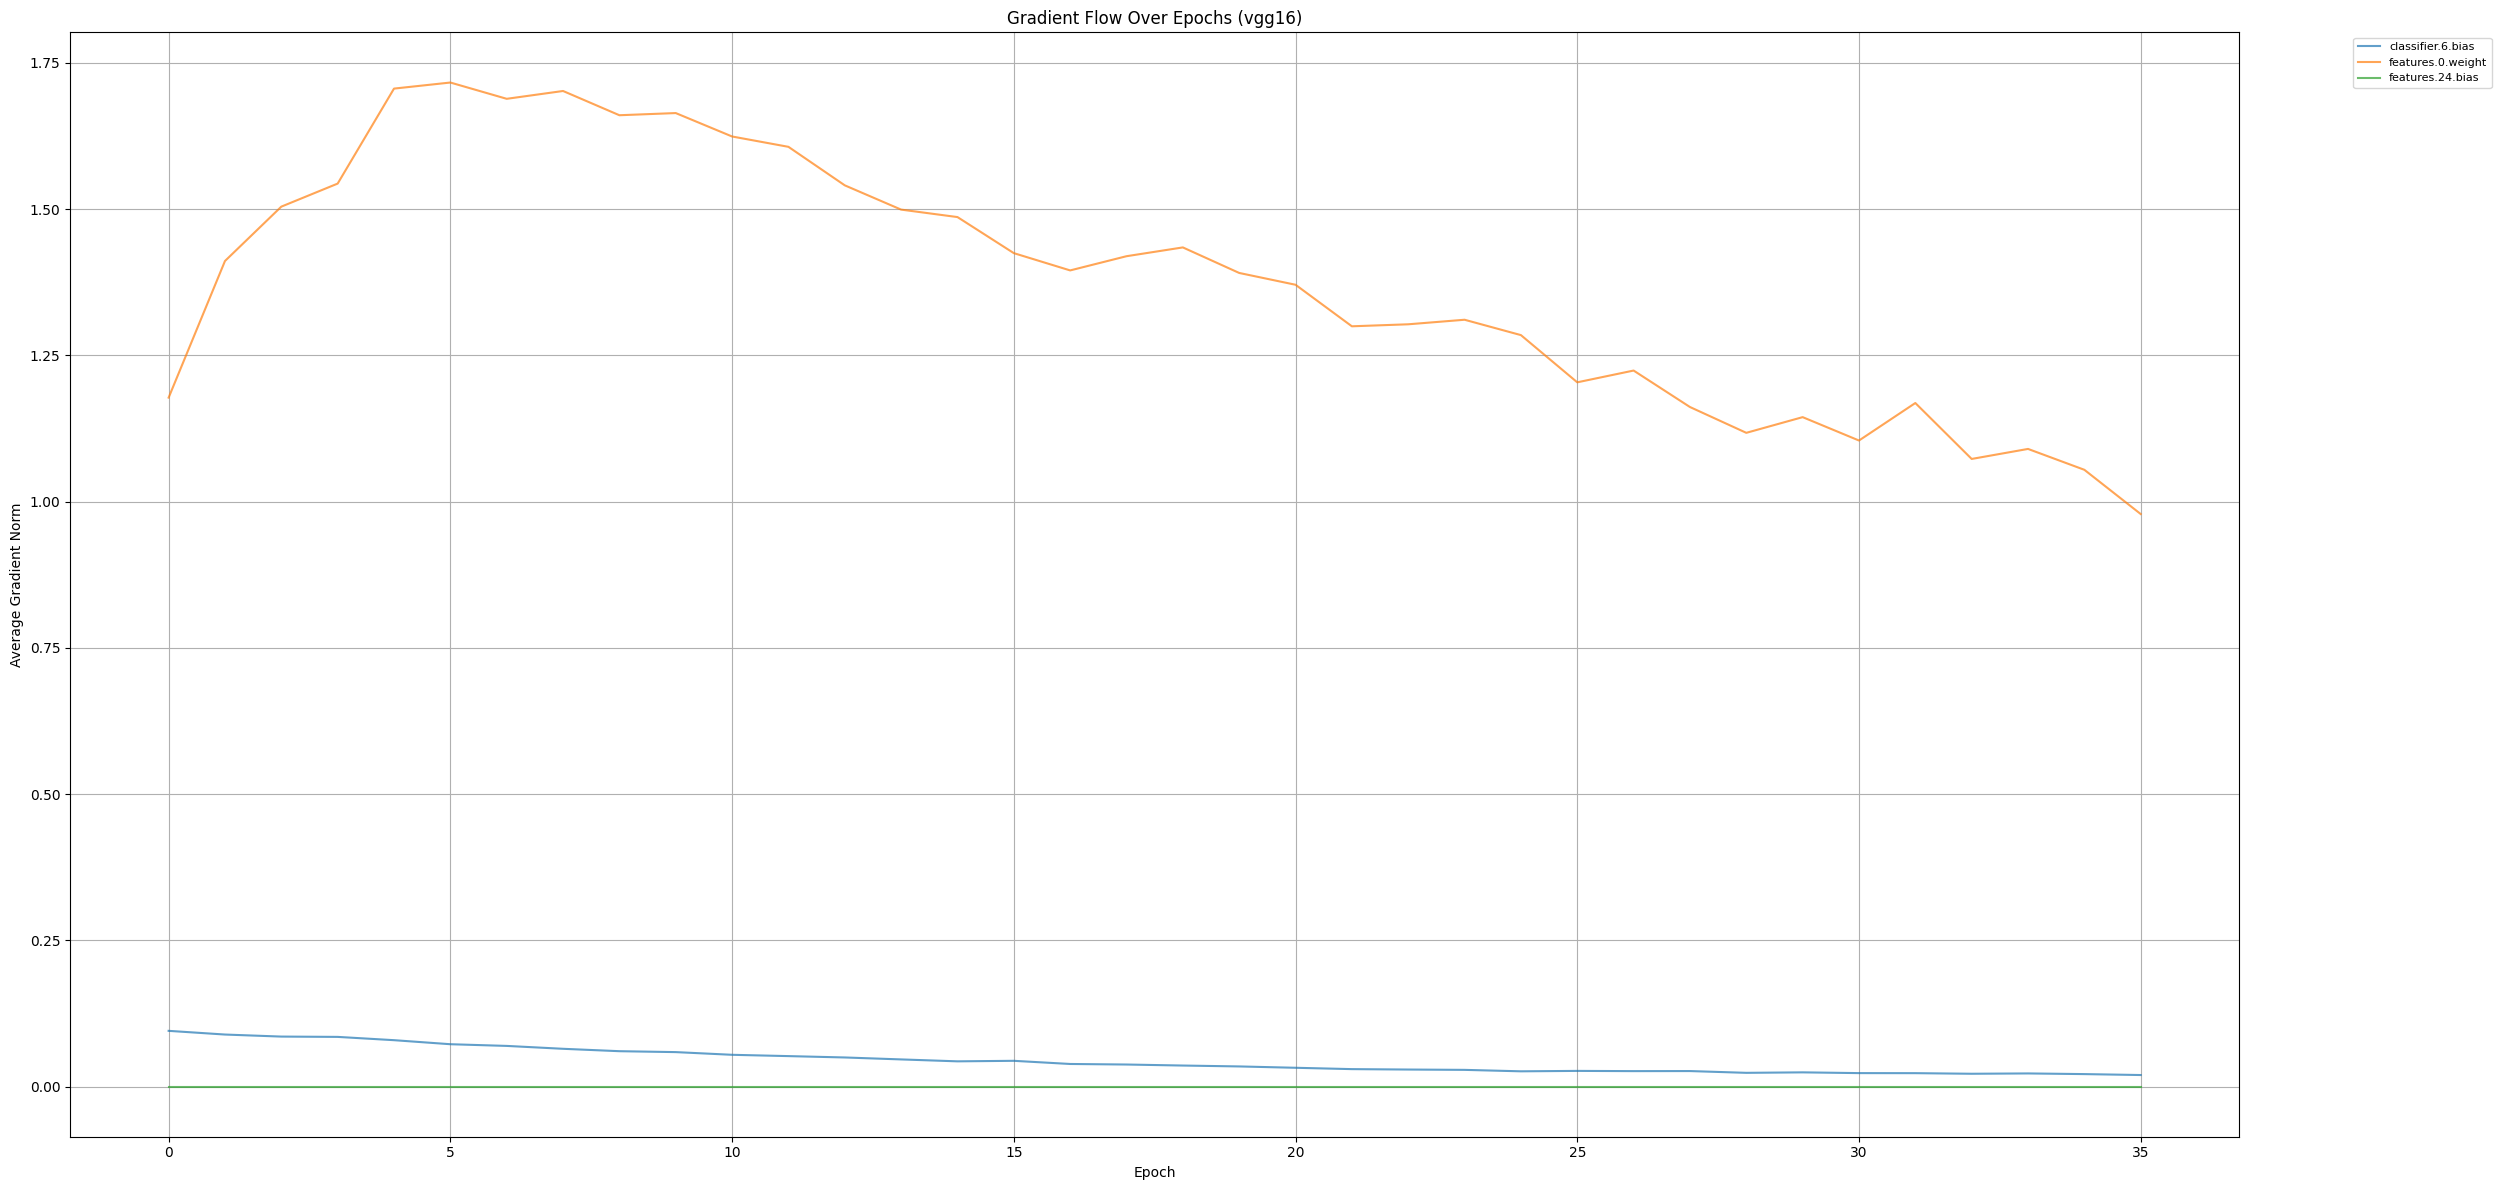

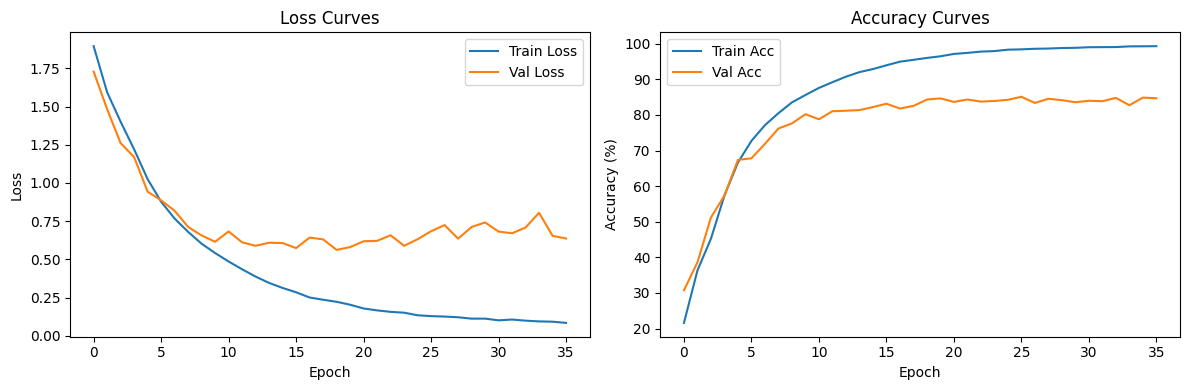

Training VGG50...
Tracking gradients for layers: ['features.0.weight', 'features.78.bias', 'classifier.6.bias']
Epoch 0: Train Loss: 2.2888, Train Acc: 11.5933%,                   Val Loss: 2.3027, Val Acc: 10.3000%
Epoch 1: Train Loss: 2.2472, Train Acc: 13.7467%,                   Val Loss: 2.2966, Val Acc: 11.3600%
Epoch 2: Train Loss: 2.2575, Train Acc: 13.1622%,                   Val Loss: 2.1419, Val Acc: 15.0000%
Epoch 3: Train Loss: 2.1417, Train Acc: 18.0200%,                   Val Loss: 2.0971, Val Acc: 19.4400%
Epoch 4: Train Loss: 1.9677, Train Acc: 21.7022%,                   Val Loss: 1.9598, Val Acc: 22.6000%
Epoch 5: Train Loss: 1.9140, Train Acc: 23.6133%,                   Val Loss: 2.0623, Val Acc: 21.7000%
Epoch 6: Train Loss: 1.8689, Train Acc: 26.0311%,                   Val Loss: 2.0718, Val Acc: 17.7600%
Epoch 7: Train Loss: 1.8472, Train Acc: 27.4578%,                   Val Loss: 1.8703, Val Acc: 25.7000%
Epoch 8: Train Loss: 1.8245, Train Acc: 28.1756%,       

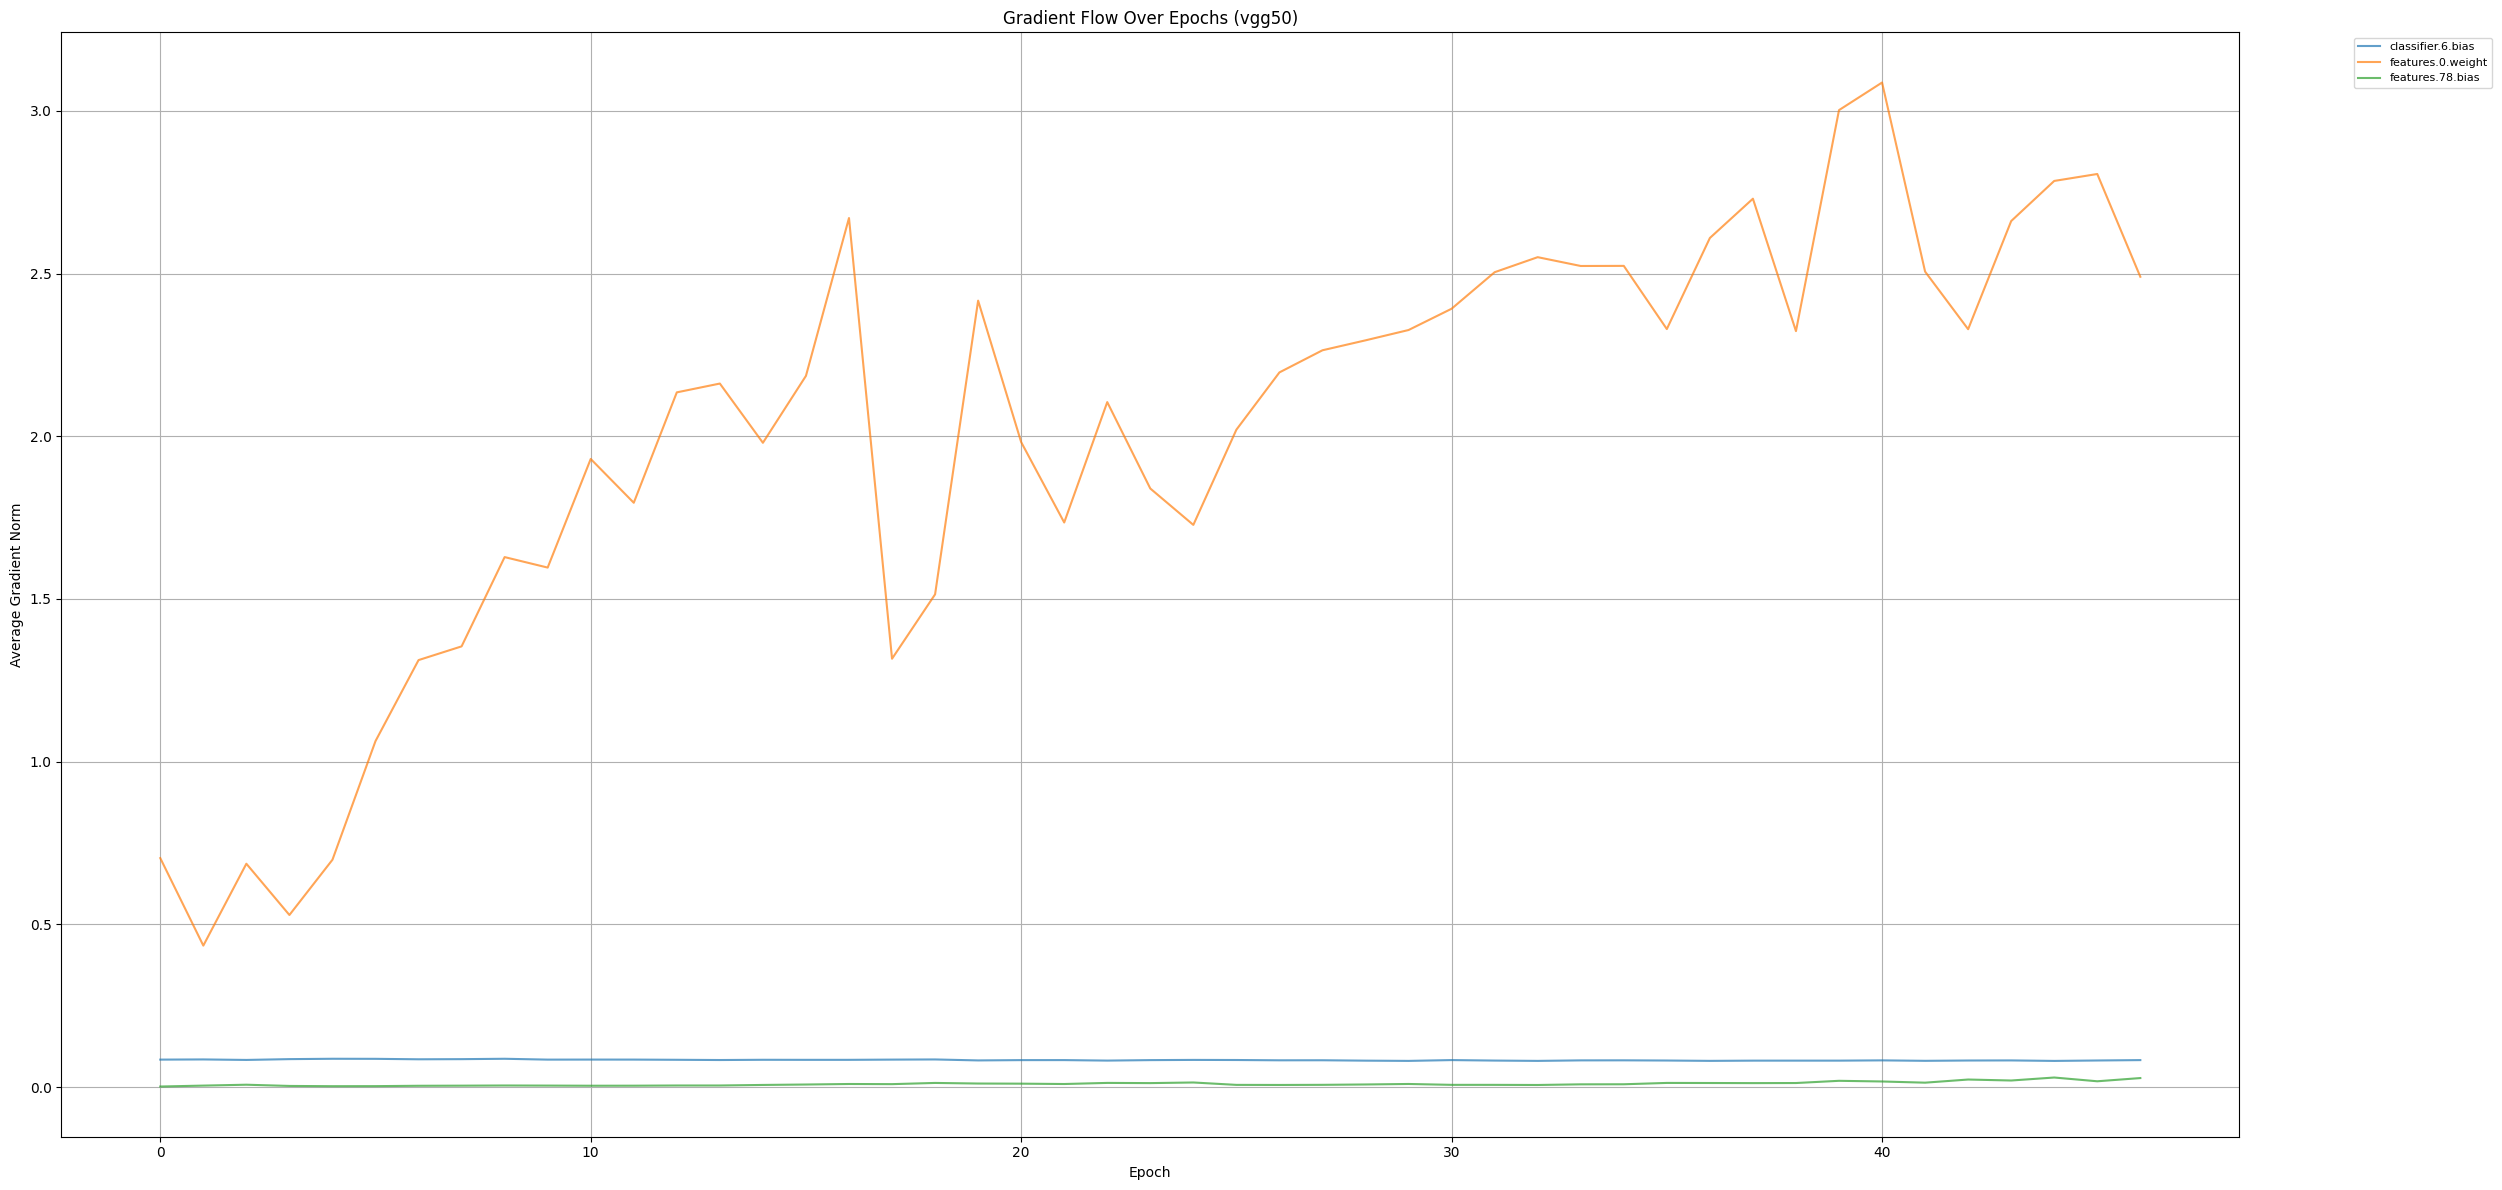

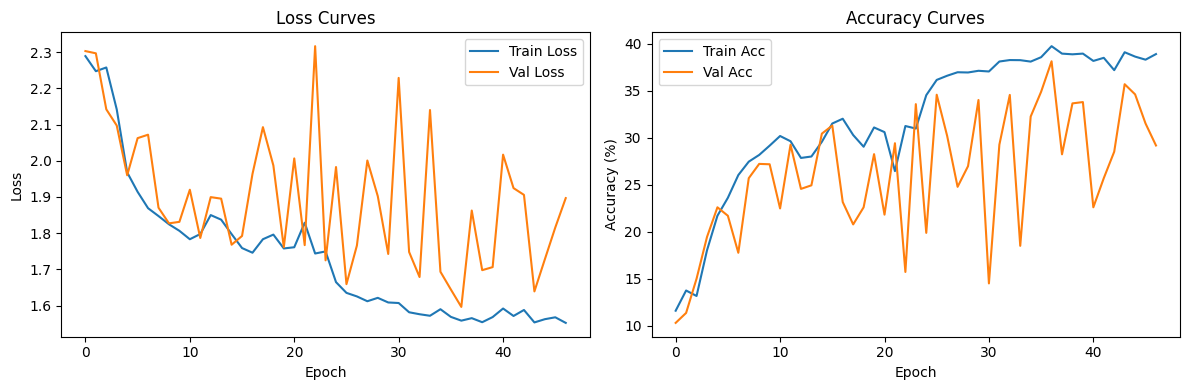

In [52]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
import sys


def main():
    # Load configuration
    config = Config()

    # Set device
    device = torch.device(config.device)
    print(f"Using device: {device}")

    # Data transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load CIFAR-10 dataset
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Split training data into train and validation
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

    # Create models
    vgg16 = VGG16(num_classes=config.num_classes).to(device)
    vgg50 = VGG50(num_classes=config.num_classes).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    # Train VGG16
    print("Training VGG16...")
    vgg16_optimizer = optim.Adam(vgg16.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    vgg16_trainer = Trainer(
        model=vgg16,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=vgg16_optimizer,
        device=device,
        config=vars(config),
        model_name='vgg16'
    )
    vgg16_trainer.train()
    vgg16_trainer.save_results()

    # Train VGG50
    print("Training VGG50...")
    vgg50_optimizer = optim.Adam(vgg50.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    vgg50_trainer = Trainer(
        model=vgg50,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=vgg50_optimizer,
        device=device,
        config=vars(config),
        model_name='vgg50'
    )
    vgg50_trainer.train()
    vgg50_trainer.save_results()

if __name__ == '__main__':
    main()


In [53]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Dict

class ModelComparator:
    def __init__(
        self,
        models: Dict[str, nn.Module],
        test_loader: DataLoader,
        criterion: nn.Module,
        device: str
    ):
        self.models = models
        self.test_loader = test_loader
        self.criterion = criterion
        self.device = device

    def evaluate_models(self) -> Dict[str, Dict[str, float]]:
        results = {}
        for name, model in self.models.items():
            print(f"Evaluating {name}...")
            model.eval() # Set model to evaluation mode
            total_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, targets in self.test_loader:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = model(inputs)

               
                    if isinstance(outputs, tuple):
                        outputs = outputs[0] 

                    loss = self.criterion(outputs, targets)

                    total_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()

            avg_loss = total_loss / len(self.test_loader)
            accuracy = 100. * correct / total

            results[name] = {
                'test_loss': avg_loss,
                'test_accuracy': accuracy
            }
            print(f"{name}: Test Loss: {avg_loss:.4f}, Test Acc: {accuracy:.2f}%")

        return results


In [54]:
# compare_models.py
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import sys

def main():
    # 1. 설정 로드
    config = Config()

    # 2. 디바이스 설정 
    device = torch.device(config.device)
    print(f"Using device: {device}")

    # 데이터 변환 정의
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # CIFAR-10 테스트 데이터셋 로드
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

    # 3. 모델 인스턴스화 및 최적 가중치 로드
    # 모델들을 해당 디바이스로 이동
    vgg16 = VGG16(num_classes=config.num_classes).to(device)
    vgg50 = VGG50(num_classes=config.num_classes).to(device)
    inception = InceptionNet(num_classes=config.num_classes).to(device)
    inception50 = Inception50(num_classes=config.num_classes).to(device)

    # 학습된 최적 가중치 로드
    try:
        vgg16.load_state_dict(torch.load(os.path.join(config.checkpoint_dir, 'vgg16_best.pth'), map_location=device))
        vgg50.load_state_dict(torch.load(os.path.join(config.checkpoint_dir, 'vgg50_best.pth'), map_location=device))
        inception.load_state_dict(torch.load(os.path.join(config.checkpoint_dir, 'inception_best.pth'), map_location=device))
        inception50.load_state_dict(torch.load(os.path.join(config.checkpoint_dir, 'inception50_best.pth'), map_location=device))
        print("All model weights loaded successfully.")
    except FileNotFoundError as e:
        print(f"Error loading model weights: {e}")
        print("Please ensure you have trained the models and saved their 'best.pth' files in the 'checkpoints' directory.")
        return 

    # 4. 손실 함수 정의
    criterion = nn.CrossEntropyLoss()

    # 5. ModelComparator 인스턴스 생성
    # 비교할 모델들을 딕셔너리 형태로 전달
    models_to_compare = {
        'VGG16': vgg16,
        'VGG50': vgg50,
        'Inception': inception,
        'Inception50': inception50
    }

    comparator = ModelComparator(
        models=models_to_compare,
        test_loader=test_loader,
        criterion=criterion,
        device=device
    )

    # 6. evaluate_models 함수 호출
    evaluation_results = comparator.evaluate_models()

    print("\n--- Final Evaluation Results ---")
    for model_name, metrics in evaluation_results.items():
        print(f"{model_name}:")
        print(f"  Test Loss: {metrics['test_loss']:.4f}")
        print(f"  Test Accuracy: {metrics['test_accuracy']:.2f}%")

if __name__ == "__main__":
    main()

Using device: cuda
All model weights loaded successfully.
Evaluating VGG16...
VGG16: Test Loss: 0.7022, Test Acc: 84.34%
Evaluating VGG50...
VGG50: Test Loss: 1.5627, Test Acc: 38.76%
Evaluating Inception...
Inception: Test Loss: 1.0549, Test Acc: 75.86%
Evaluating Inception50...
Inception50: Test Loss: 1.0070, Test Acc: 76.09%

--- Final Evaluation Results ---
VGG16:
  Test Loss: 0.7022
  Test Accuracy: 84.34%
VGG50:
  Test Loss: 1.5627
  Test Accuracy: 38.76%
Inception:
  Test Loss: 1.0549
  Test Accuracy: 75.86%
Inception50:
  Test Loss: 1.0070
  Test Accuracy: 76.09%


## 실험 결과 표
| **모델 구조** | **1번 실험 정확도** |
| --- | --- |
| VGG-16 | 0.8434 |
| VGG-50 | 0.3876 |
| Inception-v1 | 0.7586 |
| Inception-50 | 0.7609 |

## 분석

1. 깊이에 따른 성능 변화
- VGG-16은 비교적 얕은 구조임에도 불구하고 84.3%의 높은 정확도를 달성하였다.

- 반면, VGG-50은 층 수를 크게 확장했음에도 불구하고 정확도가 38% 수준으로 급격히 하락하였다. 이는 gradient 소실(vanishing gradient), 과도한 모델 복잡도, 비효율적인 파라미터 사용 등이 복합적으로 작용한 결과로 해석된다.

- Inception 계열에서는 Inception-v1과 Inception-50 간 성능 차이가 크지 않으며, 두 모델 모두 75~76% 수준의 안정적인 정확도를 유지했다.
이는 Inception 구조의 모듈화된 병렬 처리와 차원 축소 설계(1x1 convolution)가 깊이 증가에 따른 부작용을 어느 정도 완화함을 보여준다.

2. 연산 효율성 비교
- VGG-16은 가장 높은 정확도를 기록했지만, 상대적으로 높은 연산량 지표(84.88)를 보였다. 이는 작은 커널을 반복하여 구성된 깊은 네트워크가 계산적으로 비효율적일 수 있음을 의미한다.

- VGG-50은 연산량은 줄었지만 성능이 심각하게 저하되어, 실용성이 떨어진다.

- Inception-v1은 상대적으로 낮은 연산량(76.44)에도 불구하고 VGG-50보다 훨씬 높은 정확도를 기록하였다.

- Inception-50은 정확도가 유지되면서도 깊이가 확장된 모델이며, 성능-효율 균형 측면에서 Inception 계열이 깊은 구조에 더 적합함을 시사한다.

![vgg16_gradient](./figs/vgg16_gradient_flow_over_epochs.png)

![vgg50_gradient](./figs/vgg50_gradient_flow_over_epochs.png)

*전체 레이어가 아닌 레이어 중 3개의 레이어만 gradient를 계산한 것은 출력을 참고해주세요.

1. Epoch 단위 Gradient 흐름 분석

- VGG-50
    - 그래디언트 norm이 낮은 레이어들은 학습 내내 거의 평평한 수준으로 유지되며, 상위 일부 레이어만 점진적으로 gradient가 증가하는 양상을 보임.
    - 이는 초기 레이어로 갈수록 gradient가 전달되지 않는 vanishing gradient 현상이 발생했음을 보여준다.
    - 전체적으로 학습 불균형이 존재하며, 이는 성능 하락(정확도 38%)과도 직접적으로 연결된다.

- VGG-16
    - 전반적으로 gradient norm이 더 크고, 여러 레이어에서 안정적인 수준으로 유지됨.
    - 다만 후반 epoch으로 갈수록 gradient가 감소하는 경향을 보이며, 이는 학습 수렴 과정에서 발생하는 자연스러운 현상으로 볼 수 있음.
    - 상대적으로 gradient 전달이 효과적으로 이루어진 안정적인 구조임을 보여줌.

- Inception-50
    - 초기 epoch에서는 gradient가 높은 수준에서 시작되지만, epoch이 진행됨에 따라 점차 완만하게 감소.
    - 모든 측정된 레이어에서 비슷한 스케일의 gradient가 관측되어, 깊은 구조에서도 gradient가 고르게 흐름을 확인할 수 있음.
    - 50층 규모의 깊은 구조임에도 gradient 소실 문제가 거의 발생하지 않음.

- Inception
    - Inception-50과 유사하게 epoch이 진행됨에 따라 전반적으로 gradient가 조금씩 감소.
    - 전반적으로 모든 레이어가 학습에 기여하고 있으며, 계층 간 gradient 불균형이 적음.
    - 구조적으로 효율적임을 시각적으로 확인할 수 있음.

2. Layer 별 Gradient 흐름 분석

- VGG-50: 초반 features.0.weight, features.78.bias 등의 레이어에서 gradient가 거의 0에 수렴하며, 상위 classifier 계층만 학습되는 현상이 나타남. 이는 네트워크 전체가 학습되지 못하고 상단 일부만 overfitting되는 문제를 시사함.

- VGG-16: 중간 depth의 레이어에서도 의미 있는 gradient가 약간 있어보이지만, 첫번째레이어에서보다는 gradient 감소가 크다.

- Inception 계열: 마찬가지로 마지막 레이어에서는 거의 gradient가 0으로 수렴한다.

## 결론
본 실험은 동일한 데이터셋(CIFAR-10)에서 네트워크 구조(VGG vs. Inception) 및 깊이(16 vs. 50 layers)의 영향을 비교 분석하였다.

결과적으로 다음과 같은 결론을 도출할 수 있다.

1. VGG 구조는 깊이를 무작정 증가시킬 경우 성능이 오히려 하락할 수 있다. 이는 residual connection이 없고, gradient 전달이 비효율적으로 이루어지기 때문이다.
2. Inception 구조는 깊이를 확장하더라도 상대적으로 안정적인 성능을 유지한다. 이는 내부 모듈의 구조적 다양성과 연산 최적화 전략(1x1 conv, 병렬 처리 등)에 기인한다.
3. 모델 선택 시 성능뿐 아니라 연산량과 구조적 효율성까지 고려해야 한다. 특히 deployment 환경에서는 Inception 계열의 구조적 이점이 더욱 부각될 수 있다.